<a href="https://colab.research.google.com/github/AshAninze/Uni-Projects/blob/main/Bias_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Measuring and Mitigating Biases with AI using FairLearn

This notebook aims to measure and mitigate biases within ML models using the Fairlearn package created by Microsoft. This colab notebook will be covering the biases within the adult dataset

# Initalisation

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#importing needed libaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from yellowbrick.classifier import ClassificationReport
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

Mounted at /content/drive


In [3]:
#loading the datasets to be used
crime = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diss/crime.csv')
adult = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diss/adult.csv')


#Building Adult Machine Learning Model

This section contains the development of the Machine Learning model before any bias mitigation

## Initalisation of the datasets


In [4]:
# displaying dataset before any preprocessing technqiues
adult.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Renaming income as the target variable




In [5]:
#renaiming income to target variable
adult = adult.rename(columns={
    'income' : 'target'
})

adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Dropping columns that are not needed

This helps improve accuracy scores by dropping irrelevant features there preventing the model from learning information that is not needed

In [6]:
# dropping columns
columns_to_drop = ['fnlwgt', 'workclass', 'education']
# axis=1 ensures that the columns are being dropped
adult.drop(columns_to_drop, axis=1, inplace=True)

### Empty Rows

No empty rows were detected

In [7]:
# This is to check wether the dataset has any missing values
missing= adult.isna().sum()
print (missing)


age               0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
captial-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64


### One hot encoding (Brownlee, 2020)

In [8]:
#importing required packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [9]:
#creating a list of all columns within the dataset
columns = adult.columns.tolist()
#The encoder - encodes values between 1 and number of columns - 1
encoder = LabelEncoder()

#for loop encoding all columns within the dataset
for i in range(len(columns)):
  adult[columns[i]] = encoder.fit_transform(adult[columns[i]])

#Displays the encoded dataset
adult.head()



,age,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,target
0,22,12,4,1,1,4,1,25,0,39,39,0
1,33,12,2,4,0,4,1,0,0,12,39,0
2,21,8,0,6,1,4,1,0,0,39,39,0
3,36,6,2,6,0,2,1,0,0,39,39,0
4,11,12,2,10,5,2,0,0,0,39,5,0


In [10]:
#splitting the dataset into features and target
X = adult.drop('target', axis = 1)
y = adult['target']
#spliting data into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 42)

# The following is the shapes of the individulal train and test sets for x and y
X_train.shape

(26048, 11)

In [11]:
X_test.shape

(6513, 11)

In [12]:
y_train.shape

(26048,)

In [13]:
y_test.shape

(6513,)

## EDA

In [14]:
# data frame of the test set to prevent data leakage
df = pd.concat([X_train, y_train], axis=1)

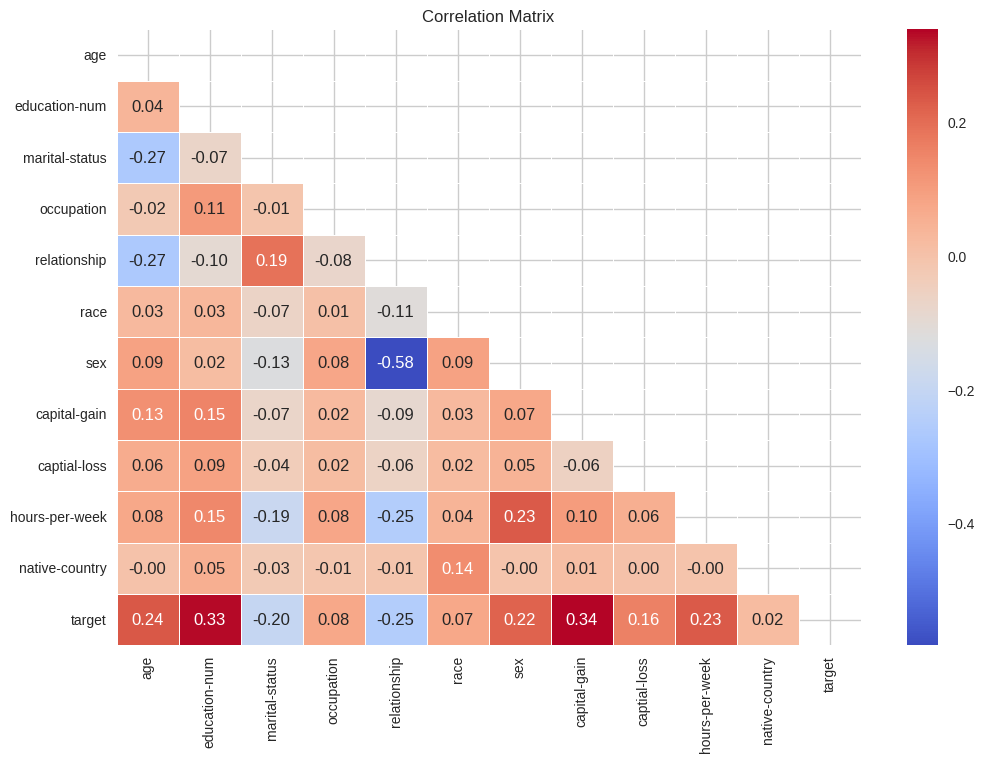

In [15]:
#calulates the correlation matrix for adult dataset
correlation_matrix = df.corr()
#plots the size of the figure
plt.figure(figsize=(12, 8))
# hides the upper half of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
#heatmap to easily diffrintiate between postive and negative correlations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
#titling
plt.title('Correlation Matrix')


plt.show()

## Preprocessing


In [16]:
#standardising training data for the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[-0.40880641,  1.13370219,  0.9234708 , ..., -0.20532816,
         0.79753281,  0.29281769],
       [-0.18882908,  0.35704925, -0.40782773, ...,  4.39062258,
         0.79753281,  0.29281769],
       [ 1.42433802, -1.97290957,  1.58912007, ..., -0.20532816,
        -0.02710922,  0.29281769],
       ...,
       [-1.50869307, -1.19625663,  0.9234708 , ..., -0.20532816,
        -1.67639328,  0.29281769],
       [ 0.8377318 , -0.41960369, -0.40782773, ..., -0.20532816,
         3.27145891,  0.29281769],
       [-0.33548063,  1.13370219, -1.73912625, ..., -0.20532816,
         1.62217484,  0.29281769]])

In [17]:
# checking the balance of the target variable
y_train.value_counts()
y_test.value_counts()

target
0    4942
1    1571
Name: count, dtype: int64

In [18]:
#The dataset is unbalanced - oversampling to balance target values
from imblearn.over_sampling import SMOTE
over = SMOTE()
X_train, y_train = over.fit_resample(X_train, y_train)

#creating new dataframe with the balanced train data
X_train_df = pd.DataFrame(X_train, columns=X.columns)
y_train_df = pd.DataFrame(y_train, columns=['target'])

df = pd.concat([X_train_df, y_train_df], axis=1)

## ML Models

### Random Forest Model

In [19]:
# RFM for the dataset

#defining the RFM model -  specifying the number of trees in the RM (100)
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred)
print(rf_acc)

0.8404729003531399


#### Cross validation


In [20]:
#defining the amount of folds to use in CV -  this defines how many times the model is trained

#Performing CV
cv_scores = cross_val_score(clf_rf, X_train, y_train, cv=6)
print(cv_scores)



[0.82071894 0.82587593 0.92143182 0.91885333 0.92354369 0.91884102]


### Hyperparameters

This section will involve using GridSearchCV to find the best parameters for my machine learning model to improve the accuracy score

In [21]:
from sklearn.model_selection import GridSearchCV

#Different parameters to iterate from
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#intialising the grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')

#performing the grid search
grid_search.fit(X_train, y_train)

#getting the best params
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

#using the best model for the prediction
y_pred = best_model.predict(X_test)

#calulating the new accuracy score
rf_acc = accuracy_score(y_test, y_pred)
print("Improved Random Forest accuracy:", rf_acc)

KeyboardInterrupt: 

This section is using a randomised paramater search while using Cross Validation. Random search is utilized as it has a shorter processing time compared to GridSearchCV

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint #for randomised numbers

param= {
    'n_estimators': randint(50, 150), # random number from 50 - 150
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10) # random split
}

random = RandomizedSearchCV(estimator=clf_rf,
                            param_distributions=param,
                            n_iter=10, cv =6, scoring= 'accuracy',
                            random_state=42)

random.fit(X_train, y_train)

best_params = random.best_params_
best_estimator = random.best_estimator_

In [ ]:
print(best_params)

In [ ]:
y_pred = best_estimator.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred)
print("Improved Random Forest accuracy:", rf_acc)

In [ ]:
#classifiction report
report = classification_report(y_test, y_pred, target_names=['Over 50k', 'Under 50K'], output_dict=True)

#formating
def format_classification_report(report):
    formatted_report = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Support':<10}\n"
    for class_name, metrics in report.items():
        if class_name in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        formatted_report += f"{class_name:<15}{metrics['precision']:.2f}{' ' * 6}{metrics['recall']:.2f}{' ' * 6}{metrics['f1-score']:.2f}{' ' * 6}{metrics['support']}\n"
    return formatted_report

# Print the formatted report
print(format_classification_report(report))

#Fairlearn

## Initaisation






In [ ]:
pip install fairlearn matplotlib

In [ ]:
# importing packages needed
from fairlearn.metrics import MetricFrame
from fairlearn.reductions import DemographicParity, ExponentiatedGradient





## Preparing the data


In [ ]:
y_true = df['target']
sex = df['sex']


In [ ]:
y_pred_train = clf_rf.predict(X_train)
mf = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred_train, sensitive_features=sex)
mf.overall
mf.by_group
#len(y_pred)
#len(y_true)